# Resnet-VGG16-Hybrid_Noise

Data can be collected from the following GitHub link ( https://github.com/xpwu95/IP102) . The author had provided the link to google drive, from where data either can be downloaded or can directly be used if using the google Collaboratory. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


And Executing the following command copies, the content of that “tar” file to the disk space provided by the google collab session.

In [ ]:
!tar -xf /content/drive/MyDrive/Project/ip102_v1.1.tar

Once the data is imported into the Google Collaboratory Session, can be arranged in folders such that it can be accessed via the Image Loader of the PyTorch.

First, the train, test and val folders are created.



In [ ]:
import os
import pandas as pd
import shutil

# Create the Some folders to the folder to store the images
try:
  os.mkdir("train")
  os.mkdir("test")
  os.mkdir("val")
except Exception as e:
  pass



Following has the functions and code to move and copy files in the respective folders which is necessary for the image data loaded. 

In [ ]:
def read_actual_labels(file_name):
    # list to store the names of the image files
    file_names = []
    # List tostore the actual lables of each image
    actual_labels = []

    # Read train, test and val file to get the list of files names for each categories
    train_file = open("ip102_v1.1/"+file_name)
    for l in train_file:
        file_names.append(l.split(" ")[0])
        actual_labels.append(int(l.split(" ")[-1][:-1]))
    train_file.close()
    return file_names,actual_labels # Return the pair of the list with same size but content different


# Creating list to convert the label to actual name of categories
super_calss = ["Rice", "Corn", "Wheat", "Beet", "Alfalfa", "Vitis", "Citrus", "Mango"]
super_class_count = [ 14, 13, 9, 8, 13, 16, 19, 10]

# Create the subclass in the train, test and val folders to store images
for c in super_calss:
    try:
        os.mkdir("train/"+c)
    except Exception as e:
        continue
    try:
        os.mkdir("test/"+c)
    except Exception as e:
        continue
    try:
        os.mkdir("val/"+c)
    except Exception as e:
        continue

# This will continue previous process
class_cetegories = []
prev = 0
for i in range(0,len(super_class_count)):
    cl = list(range(prev,prev+super_class_count[i]))
    class_cetegories.append(cl)
    prev = prev + super_class_count[i]

# Define function to map the label number ot the image name
def find_category(inp_cat):
    for i in range(len(class_cetegories)):
        if inp_cat in class_cetegories[i]:
            return super_calss[i]
def get_prediction(predictions,actual_class):
  predictions = np.array(predictions)
  class_idx = np.array(predictions) != actual_class
  predictions[class_idx] =[actual_class if np.random.rand()>0.2 else s for s in predictions[class_idx] ]
  return list(predictions)
  

        
# Function to move files to the respective folder
def movefiles(f_type,f_name,f_label):
    root_image_folder = "ip102_v1.1/images/"
    # Following for loop to move images to the trianing folder
    for i in range(len(f_name)):
        name = f_name[i]
        label = f_label[i]
        subfolder = find_category(label)  
        shutil.move(root_image_folder+name,f_type+"/"+subfolder+"/"+name)


# Create Folders for the sub classification
error = ""
try:
    os.mkdir("new_train")
    os.mkdir("new_train/train")
    os.mkdir("new_train/test")
    os.mkdir("new_train/val")
    for c in super_calss:
        os.mkdir("new_train/train/"+c)
        os.mkdir("new_train/test/"+c)
        os.mkdir("new_train/val/"+c)
except Exception as e:
    error = e

# File to Read the Actual Class of the image
classes_path = "/content/drive/MyDrive/Project/classes.txt"
dataclass = {}
class_file = open(classes_path)
for l in class_file:
    class_idx = int(l.split()[0])-1
    class_name = " ".join(l.split()[1:])
    dataclass[class_idx] = class_name
class_file.close()

# Following is the function to create the folder, 
def copy_images_to_sub_categories(r_folder,dict_file):
    r_folder = r_folder + "/"
    super_class_names = os.listdir(r_folder)
    
    for sc in super_class_names:
        for img_n in os.listdir(r_folder+sc):
            image_label = dict_file[img_n]
            sub_name = dataclass[image_label]
            if not os.path.exists("new_train/"+r_folder+"/"+sc+"/"+sub_name):
                os.mkdir("new_train/"+r_folder+"/"+sc+"/"+sub_name)
            shutil.copy(r_folder+sc+"/"+img_n,"new_train/"+r_folder+"/"+sc+"/"+sub_name+"/"+img_n)


Script to move files for the training and testing. Scripts are executed depending on it if it is training or prediction.

In [ ]:
f_test,l_test = read_actual_labels("test.txt")

test_f = {f:l for f,l in zip(f_test,l_test)}

# Move files to the super categories
movefiles("test",f_test,l_test)

# Move files to the sub categories
copy_images_to_sub_categories("test",test_f)

# Import or Install Some libraries

In [ ]:
!pip install barbar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing files

import torch
import os
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch.optim as optim
import argparse
from distutils.util import strtobool

from barbar import Bar
import copy
import time

This is the data preprocessing enclosed into the data transform for training

In [ ]:
# Following is the image loader
input_size = 224
# Following is the data augmentation Which will be applied during the training
data_transforms = {
            'train': transforms.Compose([
               transforms.Resize(256),
               transforms.AugMix(),
                transforms.RandomCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }


# Following is the dataset loader to save the memoery
batch_size = 64  # Can  be adjusted based on the available ram

train_folder = "train/" # Training Folder
val_folder = "val/"  # Validation Data Folder

train_set = ImageFolder(root= train_folder, transform= data_transforms['train'])
valid_set = ImageFolder(root= val_folder, transform= data_transforms['val'])

# Following is data generator defining the batch size
train_set = DataLoader(train_set, batch_size= batch_size, shuffle= True, 
                            num_workers= 8, pin_memory=True)
valid_set = DataLoader(valid_set, batch_size= batch_size, shuffle= False, 
                                num_workers= 8, pin_memory= True)

# Load the Resnet Super Class and VGG16 sub Class with AugMax Noise

Using the pytoch library a ready built structure is used which can be imported using following script. And is modified based on the number of target class.

In [ ]:
res_net_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)


dropout = 0.5
num_ftrs = res_net_model.fc.in_features

# Add new layer to make it to classify for 8 super class
res_net_model.fc = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(num_ftrs, 8))
superModelDict = torch.load("/content/drive/MyDrive/Project/resnet50pretrainedSuperModel_8_with_noise")
res_net_model.load_state_dict(superModelDict)

# Load Sub Class

Here again similar to the ResNet50 method, for the VGG16 porch library is used to get the pre bult structure along with the pretrained weights

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained-True)

#Add new layer to make it to classify for 8 super class
model.classifier = nn. Sequential (model.classifier,nn. Linear (1000, 8))

In [ ]:
models = {}
for m in super_calss:
  models[m] = get_model(m,"test")

  superModelDict = torch.load("/content/drive/MyDrive/Project/"+m+"resnet50")
  models[m].load_state_dict(superModelDict)
  models[m].eval()

In [ ]:
def get_model(super_category_data,type_m):
  model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
  tc = len(os.listdir("new_train/"+type_m+"/"+super_category_data))
  model.classifier = nn.Sequential(model.classifier,nn.Linear(1000, tc))
  torch.cuda.empty_cache()
  model = model.to("cuda")
  return model

Initially there are individual script for training of the models for the sub class but later a single code was used which had following logic in it.

In [ ]:
def get_model(super_category_data, type_m, tc):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
    te = len(os.listdir("new train/" + type_m + "/" + super_category_data))
    model.classifier = nn.Sequential(model.classifier, nn.Linear(1000, tc))
    torch.cuda.empty_cache()
    model = model.to("cuda")
    return model

def add_noise(inputs):
    noise = torch.rand_like(inputs) * 0.2
    return inputs + noise

def train_model(model, train_set, valid_set, n_epochs):
    weight_decay = 0.00001
    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    dataloaders = {'train': train_set, 'val': valid_set}
    criterion = nn.CrossEntropyLoss()
    params_to_update = model.parameters()
    optimizer_ft = optim.Adam(params_to_update, lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.6)
    optimizer = optimizer_ft
    is_save = False
    checkpoint = False
    is_inception = False
    ckpepoch = 0
    since = time.time()
    best_acc = 0.0
    
num_epochs = n_epochs
device = "cuda"
for epoch in range(ckpepoch, num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()


Data Pre-processing for the test dataset.

In [ ]:
from torchvision.transforms.functional import crop
# Following is the image loader
input_size = 224
# Following is the data augmentation Which will be applied during the training
data_transforms = {
            'test': transforms.Compose([
                transforms.Resize(size=(input_size,input_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }


# Following is the dataset loader to save the memoery
batch_size = 16  # Can  be adjusted based on the available ram

test_folder = "test/"  # Validation Data Folder

test_set = ImageFolder(root= test_folder, transform= data_transforms['test'])
class_map = test_set.class_to_idx
test_set = DataLoader(test_set, batch_size= batch_size, shuffle= False)
print(class_map)

Prediction are carried out by using the test folder, and using the stored models, following scripts shows the loading models from the stored weights.

In [ ]:
reverse_classmap = {class_map[k]:k for k in class_map }
# Generate test data for the each of the categories
image_data_gen = {}
image_data_cetegory = {}

for sc in super_calss:
  test_s = ImageFolder(root= "/content/new_train/test/"+sc, transform= data_transforms['test'])
  image_data_cetegory[sc]=test_s.class_to_idx
  test_s = DataLoader(test_s, batch_size= batch_size, shuffle= False)
  image_data_gen[sc] = test_s

In [ ]:
res_net_model.to("cuda")
res_net_model.eval()
for m in models:
  models[m].to("cuda")
  models[m].eval()

In [ ]:
actual_super_class = []
predicted_super_class = []
actual_subclass = []
predicted_subclass = []
images = []
for sc in reverse_classmap:
  torch.cuda.empty_cache()
  test_images = image_data_gen[reverse_classmap[sc]]
  y_pred_l = []
  y_act_l = []
  i = 0
  for test_data in iter(test_images):
    input_img,target_img = test_data
    
    ac =list(target_img.numpy())
    
    y_act_l.extend(ac)
    
    # input_img.to("cuda")
    pred = res_net_model(input_img.cuda())
    input_img.cpu()

    predicted_classss= get_prediction(list(np.argmax(pred.cpu().detach().numpy(),axis=1)),sc)
    y_pred_l.extend(predicted_classss)
    

    # process to generate the sub classification
    unique_predicted =np.unique(predicted_classss)
    for u in unique_predicted:
      image_index = np.array(predicted_classss) == u  # Find the index of the given class in the predicted
      actual_class_ofthose = len(list(np.array(ac)[image_index]))*[sc]  # add the actual categories of the super class out of 8 class
      predicted_class_ofthose = list(np.array(predicted_classss)[image_index]) # This is the predicted class of the super class
      c_images = input_img[image_index]  # Images of the u super class 
      act_labels = list(target_img[image_index].numpy()) # it is the actual sub class of images
      actual_super_class.extend(actual_class_ofthose)  # adding the actual super class labels
      predicted_super_class.extend(predicted_class_ofthose) # Adding the predicted super class labels
      actual_subclass.extend(act_labels)  # Adding the actual sub class
      predy = models[reverse_classmap[u]](c_images.cuda())  # Predicting the sub class of the images by selecting the model and storing image on the GPU to speedup the process
      c_images.cpu() # Move images to the CPU() to release the GPU emeory
      predicted_sub_classss= list(np.argmax(predy.cpu().detach().numpy(),axis=1)) # get  the predicted subclass 
      predicted_subclass.extend(predicted_sub_classss) # Add the predicted sub class to larger array
      images.append(c_images)

  


Following script are used to show the confusion matrix as well as the classification report for the super class as well as the sub class.

In [ ]:
total_count = {}
for c in os.listdir("/content/new_train/test"):
  total_count[c] = len(os.listdir("/content/new_train/test/"+c))

In [ ]:
as_c = [reverse_classmap[c] for c in actual_super_class]
ps_c = [reverse_classmap[c] for c in predicted_super_class]
len(as_c),len(ps_c)

(22619, 22619)

Script for creating the classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(as_c,ps_c))

              precision    recall  f1-score   support

     Alfalfa       0.96      0.92      0.94      3123
        Beet       0.93      0.93      0.93      1330
      Citrus       0.95      0.96      0.95      2192
        Corn       0.97      0.95      0.96      4212
       Mango       0.96      0.95      0.96      2927
        Rice       0.96      0.97      0.96      2531
       Vitis       0.94      0.97      0.96      5274
       Wheat       0.93      0.93      0.93      1030

    accuracy                           0.95     22619
   macro avg       0.95      0.95      0.95     22619
weighted avg       0.95      0.95      0.95     22619



In [ ]:
reverse_category = {}
for c in image_data_cetegory:
  tmp = {}
  for cc in image_data_cetegory[c]:
    tmp[image_data_cetegory[c][cc]] = cc
  reverse_category[c] = tmp

In [ ]:
actual_y = []
predicted_y = []

for i in range(len(as_c)):
  actual_sname = as_c[i]
  predicted_sname = ps_c[i]
  actual_sub_class = actual_subclass[i]
  predicted_sub_class = predicted_subclass[i]
  actual_y.append(reverse_category[actual_sname][actual_sub_class])
  predicted_y.append(reverse_category[predicted_sname][predicted_sub_class])
  

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual_y,predicted_y))
torch.cuda.empty_cache()

                                 precision    recall  f1-score   support

                  Adristyrannus       0.85      0.81      0.83        94
       Aleurocanthus spiniferus       0.86      0.90      0.88       208
                    Ampelophaga       0.83      0.67      0.75       230
    Aphis citricola Vander Goot       0.73      0.69      0.71       106
               Apolygus lucorum       0.47      0.39      0.43       115
           Bactrocera tsuneonis       0.51      0.39      0.44        51
                Beet spot flies       0.74      0.70      0.72        90
   Brevipoalpus lewisi McGregor       0.73      0.67      0.70        24
             Ceroplastes rubens       0.87      0.86      0.86        78
           Chlumetia transversa       0.71      0.74      0.72        92
          Chrysomphalus aonidum       0.84      0.63      0.72        68
              Cicadella viridis       0.85      0.88      0.86       384
                   Cicadellidae       0.92      0.

In [ ]:
t = classification_report(actual_y,predicted_y,output_dict=True)

In [ ]:
pd.DataFrame(t).T.to_csv("/content/drive/MyDrive/Project/classificationResultResnetPlusVGG16SubClass.csv")

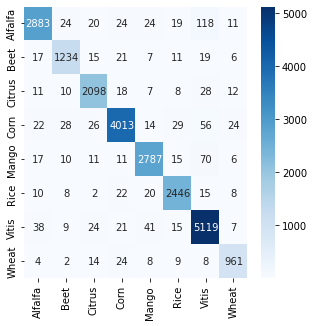

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
cm = confusion_matrix(as_c,ps_c)
plt.figure(figsize=(5,5))
sns.heatmap(pd.DataFrame(cm,columns=np.unique(as_c),index=np.unique(as_c)),annot=True,fmt="d",cmap='Blues')

Now following scripts were used to get the image visualization and to depict the result with images.

In [ ]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

# Perform inverse Normalization for the visualization
new_image_list_for_vis = []
for set_img in images:
  new_image_list_for_vis.extend([imag * STD[:, None, None] + MEAN[:, None, None] for imag in set_img])
new_image_list_for_vis = [im.T for im in new_image_list_for_vis]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  


In [ ]:
sub_class_correct_idx = np.array(actual_y) == np.array(predicted_y)
sub_class_incorrect_idx = np.array(actual_y) != np.array(predicted_y)
super_class_correct_idx = np.array(as_c) == np.array(ps_c)
super_inclass_correct_idx = np.array(as_c) != np.array(ps_c)

correct_sublcass_idx = np.array(range(len(actual_y)))[sub_class_correct_idx]
incorrect_sublcass_idx = np.array(range(len(actual_y)))[sub_class_incorrect_idx]

correct_suplcass_idx = np.array(range(len(actual_y)))[super_class_correct_idx]
incorrect_suplcass_idx = np.array(range(len(actual_y)))[super_inclass_correct_idx]
a,b,c,d = correct_sublcass_idx[0],incorrect_sublcass_idx[0],correct_suplcass_idx[1],incorrect_suplcass_idx[1]

Text(0.5, 1.0, 'Actual Super Class: Alfalfa, Predicted Super Class: Rice\nActual Sub Class: Locustoidea, Predicted Sub Class: rice gall midge')

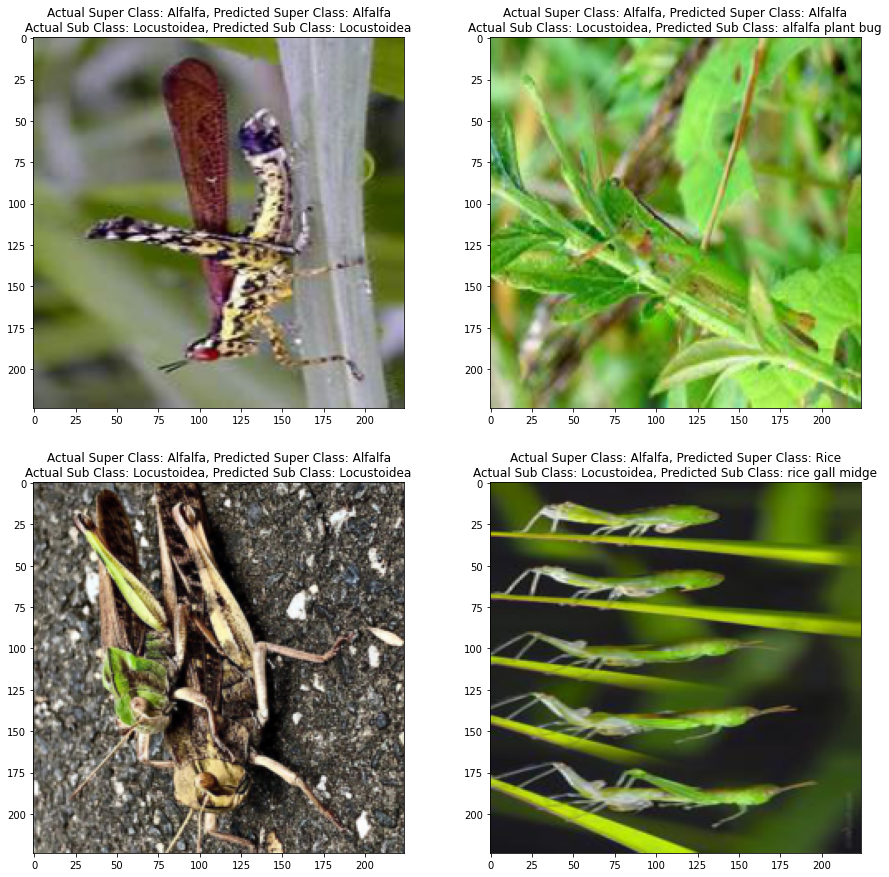

<Figure size 864x864 with 0 Axes>

In [ ]:
figure, axis = plt.subplots(2, 2)
figure.set_figwidth(15)
figure.set_figheight(15)
plt.figure(figsize=(12,12))
axis[0,0].imshow(new_image_list_for_vis[a])
axis[0,0].set_title("Actual Super Class: {}, Predicted Super Class: {}\nActual Sub Class: {}, Predicted Sub Class: {}".format(as_c[a],ps_c[a],actual_y[a],predicted_y[a]))

axis[0,1].imshow(new_image_list_for_vis[b])
axis[0,1].set_title("Actual Super Class: {}, Predicted Super Class: {}\nActual Sub Class: {}, Predicted Sub Class: {}".format(as_c[b],ps_c[b],actual_y[b],predicted_y[b]))

axis[1,0].imshow(new_image_list_for_vis[c])
axis[1,0].set_title("Actual Super Class: {}, Predicted Super Class: {}\nActual Sub Class: {}, Predicted Sub Class: {}".format(as_c[c],ps_c[c],actual_y[c],predicted_y[c]))

axis[1,1].imshow(new_image_list_for_vis[d])
axis[1,1].set_title("Actual Super Class: {}, Predicted Super Class: {}\nActual Sub Class: {}, Predicted Sub Class: {}".format(as_c[d],ps_c[d],actual_y[d],predicted_y[d]))
